In [27]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

#on charge le json
X = load_boston()
#on le met dans un dataframe
boston = pd.DataFrame(X.data, columns=X.feature_names)
#on ajoute le target au dataframe
boston['MEDV'] = X.target
#on prend juste les derniers features et le target
boston = boston.iloc[:,9:14]
#samples_features
X= boston.iloc[:, 0:4]
#samples_labels
Y= boston.iloc[:,4]

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
def train(nb_param=2, x = X, y = Y,test_set=X,labels_test = Y):
    #trains a model with a certain number of parameters, and retrieve the variance of Y and its error
    
    #Train the model
    if nb_param==2: #linear regression
        model = LinearRegression()
        model.fit(x,y)
        Y_hat = model.predict(test_set)
    if (nb_param>2 and nb_param<=6): #polynomial regression till degree 5
        poly = PolynomialFeatures(degree = nb_param) 
        X_poly = poly.fit_transform(x) 
        poly.fit(X_poly, y) 
        model = LinearRegression() 
        model.fit(X_poly, y)
        Y_hat = model.predict(poly.fit_transform(test_set))
    
    #Calculate the error
    error = labels_test-Y_hat
    
    #Calculate the variance of y in the training set
    var_Y = y.var()
    
    return var_Y, error


def loglik(var_Y , error):
    #loglikelihood of y: using mu=0, var = var_Y and y as error
    return sum(np.log(1/(np.sqrt(2*np.pi*var_Y))*np.exp((-0.5*error**2)/var_Y)))

def aic(nb_param=2, x= X, y= Y):
    var_Y, error = train(nb_param,x,y)
    llkh = loglik(var_Y, error)
    return 2*nb_param -2*llkh

def bic(nb_param=2, x=X, y=Y):
    var_Y, error = train(nb_param,x,y)
    llkh = loglik(var_Y, error)
    return -2*llkh + nb_param*np.log(len(X))

In [221]:
#Calculates AIC AND BIC for each model
aic_list=[]
bic_list=[]
for i in range(2,6): #calculates aic and bic up to 5 parameters (and therefore up to polynomials of degree 4)
    aic_list.append(aic(i))
    bic_list.append(bic(i))

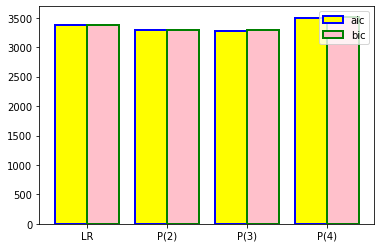

In [81]:
#PLOT AIC and BIC for each model
from matplotlib import pyplot
barWidth = 0.4
r1 = range(len(aic_list))
r2 = [x + barWidth for x in r1]

a = pyplot.bar(r1, aic_list, width = barWidth, color = ['yellow' for i in aic_list],
           edgecolor = ['blue' for i in aic_list], linewidth = 2)
b = pyplot.bar(r2, bic_list, width = barWidth, color = ['pink' for i in bic_list],
           edgecolor = ['green' for i in bic_list], linewidth = 2)
pyplot.xticks([r + barWidth / 2 for r in range(len(aic_list))], ['LR', 'P(2)', 'P(3)', 'P(4)']) #, 'P(5)'

pyplot.legend(handles=[a, b], labels=["aic", "bic"])

Here we see that the bic and aic values do not differ substantially from one model to the other. So the model selection remains a difficult task if we just take into account those estimations.

In [67]:
#HOLD OUT: separates test and train set (different at each time) using a test_ratio porcentage for the test set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [241]:
#calculates test error with hold out
def hold_out():
    Y_pred_list=[]
    Y_test_list=[]
    for i in range(2,6): #calculates hold out method for each model up to 5 parameters (and therefore up to polynomials of degree 4)
        train_set, test_set = split_train_test(boston, 0.2)
        X_train, Y_train = train_set.iloc[:,0:4], train_set.iloc[:,4]
        X_test, Y_test = test_set.iloc[:,0:4], test_set.iloc[:,4]
        var_Y_train, error = train(i, X_train, Y_train, X_test, Y_test)
        #we recuperate Y_pred of the test set by subtracting Y_test from the error and multipling by -1 (following the formula of error used in train())
        Y_pred = -1*(error - Y_test)
        Y_pred_list.append(Y_pred)
        Y_test_list.append(Y_test)
    return Y_test_list, Y_pred_list

In [243]:
Y_test_list1, Y_pred_list1 = hold_out()
Y_test_list2, Y_pred_list2 = hold_out()

In [245]:
mse1 = np.mean((np.array(Y_test_list1) - np.array(Y_pred_list1))**2)
mse2 = np.mean((np.array(Y_test_list2) - np.array(Y_pred_list2))**2)
print("mse1: " + str(mse1) + "   mse2: " + str(mse2))

mse1: 125.0886552385406   mse2: 301.00624519111466


Here we see that the mean squared error varies in a significant amout if we use another configuration of training and data set. So it is not a reliable metric to estimate the prediction error.

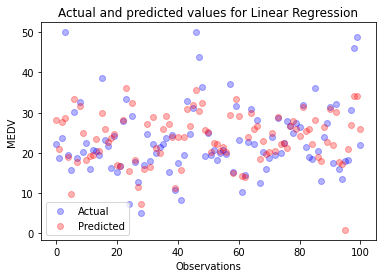

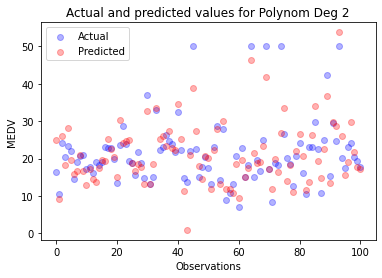

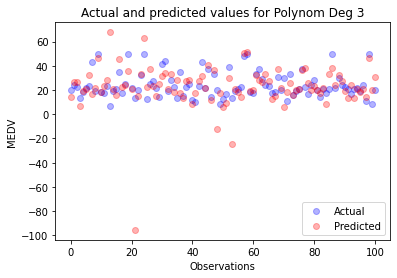

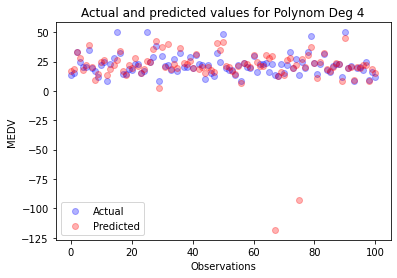

In [234]:
import matplotlib.pyplot as plt
#One way of visualizing the prediction error

def vis_pred_error(Y_test_list = Y_test_list1 , Y_pred_list = Y_pred_list1 ):
    model_name = ['Linear Regression', 'Polynom Deg 2','Polynom Deg 3', 'Polynom Deg 4']
    for i in range(4):
        _, ax = plt.subplots()

        ax.scatter(x = range(0, Y_test_list[i].size), y=Y_test_list[i], c = 'blue', label = 'Actual', alpha = 0.3)
        ax.scatter(x = range(0, Y_pred_list[i].size), y=Y_pred_list[i], c = 'red', label = 'Predicted', alpha = 0.3)
        plt.title('Actual and predicted values for ' + model_name[i])
        plt.xlabel('Observations')
        plt.ylabel('MEDV')
        plt.legend()
        plt.show()
        plt.close()
vis_pred_error()

We notice the tendency of narrowing the cloud of points once we make the model more and more complex. The linear model and the polynom of degree 2 seem the estimators that provide less aberrant points. Greater order polynoms are likely to overfit the data.

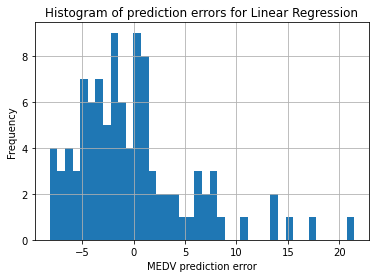

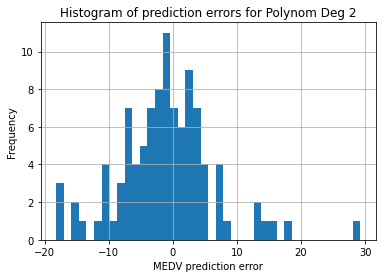

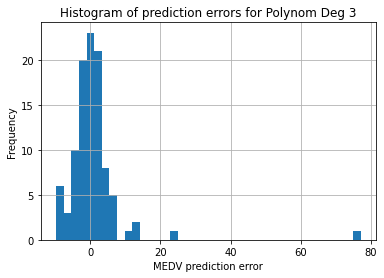

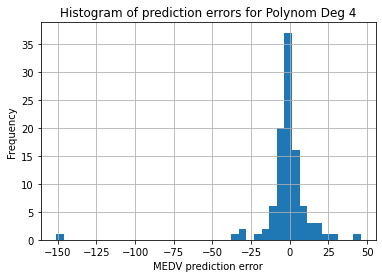

In [244]:
#Another way of visualizing the prediction error

def vis_pred_error_2(Y_test_list, Y_pred_list):
    for i in range(4):
        plt.figure()
        diff = Y_test_list[i] - Y_pred_list[i]
        diff.hist(bins = 40)
        plt.title('Histogram of prediction errors for ' + model_name[i])
        plt.xlabel('MEDV prediction error')
        plt.ylabel('Frequency')
vis_pred_error_2(Y_test_list1, Y_pred_list1)


We see that the linear module is the one with more distributed error, but they assume in general low values. Polynom of degree 3 and 4 provide a big number of predictions without error, but other estimations come with high-valued errors and also big outlier-errors.

In [247]:
#CROSS VALIDATION 
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

def plot_cross_validation(k_folds):
    for i in range(4):
        plt.figure()
        lr = LinearRegression()
        Xd=X
        if i!=0:
            Xd = PolynomialFeatures(i+2).fit_transform(X)
        # cross_val_predict returns an array of the same size as `y` where each entry
        # is a prediction obtained by cross validation:
        predicted = cross_val_predict(lr, Xd, Y, cv=k_folds)

        fig, ax = plt.subplots()
        ax.scatter(Y, predicted, edgecolors=(0, 0, 0))
        ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        plt.title("Predictions using cross validation with "+ str(k_folds)+ " folds for " + model_name[i])
    plt.show()

<Figure size 432x288 with 0 Axes>

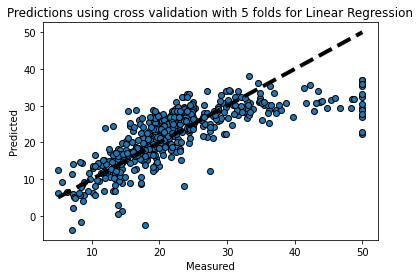

<Figure size 432x288 with 0 Axes>

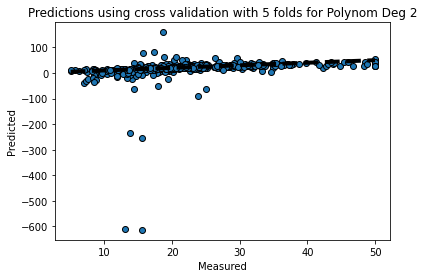

<Figure size 432x288 with 0 Axes>

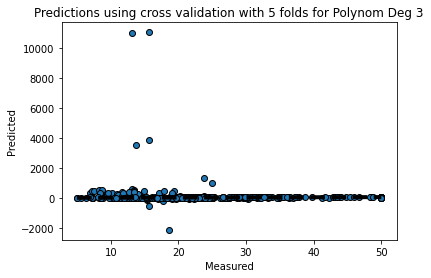

<Figure size 432x288 with 0 Axes>

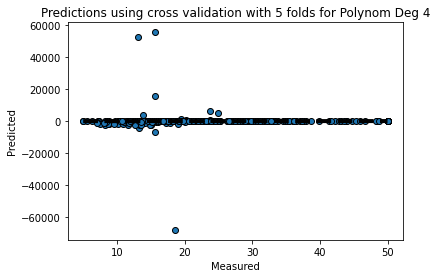

<Figure size 432x288 with 0 Axes>

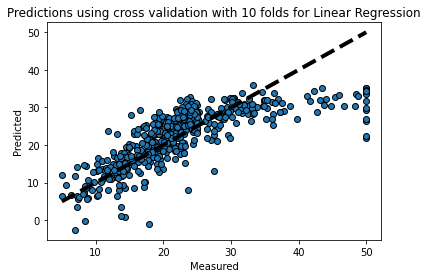

<Figure size 432x288 with 0 Axes>

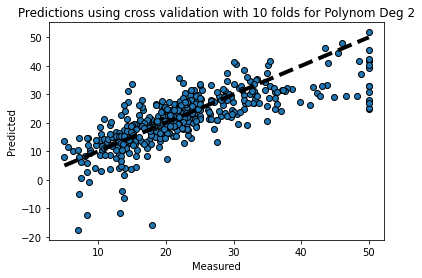

<Figure size 432x288 with 0 Axes>

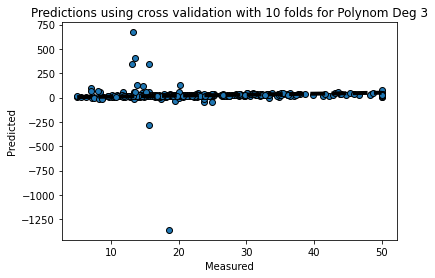

<Figure size 432x288 with 0 Axes>

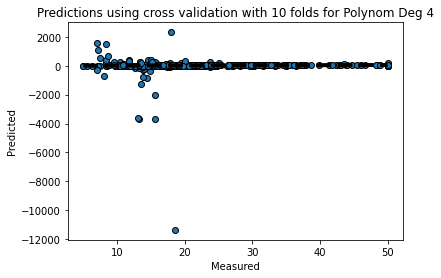

In [248]:
plot_cross_validation(5)
plot_cross_validation(10)

With cross validation we see the same logic, using 5 or 10 folds, the models with degree equal or higher than 3 tend to overfit the data and provide more outliers.